## Preprocessing Global TOA Data

Preprocessing global TOA data for historical and ssp585 simulations.

Notes: We want the data needed to compute climate sensitivity, radiative forcing, and radiative feedbacks.

In [1]:
#imports
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D 
from scipy import stats
import cftime
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [4]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

In [12]:
#time index for hist+ssp585
new_time_index_hist_ssp = pd.date_range('1850-01-01', '2099-12-31', freq = 'ME')
new_time_index_hist_ssp

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2099-03-31', '2099-04-30', '2099-05-31', '2099-06-30',
               '2099-07-31', '2099-08-31', '2099-09-30', '2099-10-31',
               '2099-11-30', '2099-12-31'],
              dtype='datetime64[ns]', length=3000, freq='ME')

In [11]:
#time index to assign abrupt4xCO2 model times to
new_time_index_abrupt =pd.date_range('1850-01-01', '1999-12-31', freq='ME')
new_time_index_abrupt 

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '1999-03-31', '1999-04-30', '1999-05-31', '1999-06-30',
               '1999-07-31', '1999-08-31', '1999-09-30', '1999-10-31',
               '1999-11-30', '1999-12-31'],
              dtype='datetime64[ns]', length=1800, freq='ME')

In [8]:
#rlut
df_hist_toa_rlut = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical'")
df_ssp585_toa_rlut = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585'")
#rsut
df_hist_toa_rsut = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical'")
df_ssp585_toa_rsut = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585'")
#rsdt
df_hist_toa_rsdt = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical'")
df_ssp585_toa_rsdt = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585'")
#models
models_toa_hist_rlut  =set(df_hist_toa_rlut.source_id)
models_toa_hist_rsut  =set(df_hist_toa_rsut.source_id)
models_toa_hist_rsdt  =set(df_hist_toa_rsdt.source_id) # all models that have toa in the historical simulations
models_toa_ssp585_rlut=set(df_ssp585_toa_rlut.source_id) #all models that have toa in the ssp585 simulations
models_toa_ssp585_rsut=set(df_ssp585_toa_rsut.source_id)
models_toa_ssp585_rsdt=set(df_ssp585_toa_rsdt.source_id)

#intersection of all of the models that have all radiation types
source_set_toa = set.intersection(models_toa_hist_rlut, models_toa_hist_rsut, models_toa_hist_rsdt, models_toa_ssp585_rlut, models_toa_ssp585_rsut, models_toa_ssp585_rsdt)
source_list_toa = list(source_set_toa)
print(len(source_list_toa))

41


In [9]:
#rlut
df_hist_toa_rlut = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_ssp585_toa_rlut = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
#rsut
df_hist_toa_rsut = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_ssp585_toa_rsut = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
#rsdt
df_hist_toa_rsdt = df.query(  "activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_ssp585_toa_rsdt = df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
#models
models_toa_hist_rlut  =set(df_hist_toa_rlut.source_id)
models_toa_hist_rsut  =set(df_hist_toa_rsut.source_id)
models_toa_hist_rsdt  =set(df_hist_toa_rsdt.source_id) # all models that have toa in the historical simulations
models_toa_ssp585_rlut=set(df_ssp585_toa_rlut.source_id) #all models that have toa in the ssp585 simulations
models_toa_ssp585_rsut=set(df_ssp585_toa_rsut.source_id)
models_toa_ssp585_rsdt=set(df_ssp585_toa_rsdt.source_id)

#intersection of all of the models that have all radiation types
source_set_toa_2 = set.intersection(models_toa_hist_rlut, models_toa_hist_rsut, models_toa_hist_rsdt, models_toa_ssp585_rlut, models_toa_ssp585_rsut, models_toa_ssp585_rsdt)
source_list_toa_2 = list(source_set_toa_2)
print(len(source_list_toa_2))

31


In [8]:
print(source_list_toa_2)

['ACCESS-CM2', 'MIROC6', 'IITM-ESM', 'CanESM5', 'EC-Earth3-Veg', 'INM-CM5-0', 'GFDL-ESM4', 'EC-Earth3-Veg-LR', 'BCC-CSM2-MR', 'CMCC-CM2-SR5', 'KACE-1-0-G', 'NESM3', 'NorESM2-LM', 'INM-CM4-8', 'AWI-CM-1-1-MR', 'MRI-ESM2-0', 'IPSL-CM6A-LR', 'FGOALS-g3', 'FGOALS-f3-L', 'NorESM2-MM', 'TaiESM1', 'CESM2-WACCM', 'EC-Earth3', 'E3SM-1-1', 'FIO-ESM-2-0', 'MPI-ESM1-2-LR', 'GFDL-CM4', 'CAMS-CSM1-0', 'CIESM', 'MPI-ESM1-2-HR', 'KIOST-ESM']


### 1.1 Look at One Model

In [84]:
#query data
#historical data
df_toa_hist_canesm5_rlut = df.query(  "activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_toa_hist_canesm5_rsut = df.query(  "activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
df_toa_hist_canesm5_rsdt = df.query(  "activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='historical' & member_id == 'r1i1p1f1'")
#load hist data as dataset
ds_toa_hist_canesm5_rlut = load_zarr_dset(df_toa_hist_canesm5_rlut)
ds_toa_hist_canesm5_rsut = load_zarr_dset(df_toa_hist_canesm5_rsut)
ds_toa_hist_canesm5_rsdt = load_zarr_dset(df_toa_hist_canesm5_rsdt)
ds_toa_hist_canesm5 = xr.concat([ds_toa_hist_canesm5_rlut, ds_toa_hist_canesm5_rsut, ds_toa_hist_canesm5_rsdt], dim = ('time'), coords = 'all', compat = 'override')
#ssp585 data
df_toa_ssp585_canesm5_rlut = df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
df_toa_ssp585_canesm5_rsut = df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
df_toa_ssp585_canesm5_rsdt = df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id=='ssp585' & member_id == 'r1i1p1f1'")
#load ssp data as dataset
ds_toa_ssp585_canesm5_rlut = load_zarr_dset(df_toa_ssp585_canesm5_rlut)
ds_toa_ssp585_canesm5_rsut = load_zarr_dset(df_toa_ssp585_canesm5_rsut)
ds_toa_ssp585_canesm5_rsdt = load_zarr_dset(df_toa_ssp585_canesm5_rsdt)
ds_toa_ssp585_canesm5 = xr.concat([ds_toa_ssp585_canesm5_rlut, ds_toa_ssp585_canesm5_rsut, ds_toa_ssp585_canesm5_rsdt], dim = ('time'), coords = 'all', compat = 'override')
#load toa data
hist_toa_canesm5 = ds_toa_hist_canesm5.rsdt - ds_toa_hist_canesm5.rsut - ds_toa_hist_canesm5.rlut
ssp585_toa_canesm5 = ds_toa_ssp585_canesm5.rsdt - ds_toa_ssp585_canesm5.rsut - ds_toa_ssp585_canesm5.rlut
#create a new toa variable
ds_toa_hist_canesm5 = ds_toa_hist_canesm5.assign(toa = hist_toa_canesm5)
ds_toa_ssp585_canesm5 = ds_toa_ssp585_canesm5.assign(toa = ssp585_toa_canesm5)

#concat hist and ssp585 data into one ds
ds_all_canesm5 = xr.concat([ds_toa_hist_canesm5, ds_toa_ssp585_canesm5], dim = 'time', coords = 'all', compat = 'override')
#ds_all_canesm5

In [ ]:
#seeing historical data
#ds_toa_hist_canesm5_rlut is good
#ds_toa_hist_canesm5_rsut has 0s
#ds_toa_hist_canesm5_rsdt has 0s 

#seeing ssp data
#ds_toa_ssp585_canesm5_rlut is good
#ds_toa_ssp585_canesm5_rsut has 0s
#ds_toa_hist_canesm5_rsdt has 0s

#checking concatted ssp data
#ds_toa_ssp585_canesm5.rlut.values
#ds_toa_ssp585_canesm.rsut.values has ALL nans
#ds_toa_ssp585_canesm5.rsdt.values has ALL nans

In [92]:
ds_all_canesm5.toa.values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [ ]:
#weights
weights = np.cos(np.deg2rad(ds_all_canesm5.toa.lat))
ds_all_canesm5 = ds_all_canesm5.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all_canesm5 = ds_all_canesm5.isel(time=slice(0,3000))
ds_all_canesm5 = ds_all_canesm5.assign(time=new_time_index_hist_ssp)
#ds_all_canesm5 = ds_all_canesm5.assign_coords(model=df_toa_hist_canesm5_rlut.source_id)

#check ds
ds_all_canesm5

In [ ]:
#hist_toa_canesm5.values has nan values
#ds_toa_hist_canesm5.toa has nan values
#this means something went wrong when we concatted our data 


#checking each indiv rlut/rsut/rsdt values
#ds_toa_ssp585_canesm5.rsdt has missinging nans
#ds_toa_ssp585_canesm_rsdt.rsdt has some 0s but no nans
#ds_toa_ssp585_canesm5_rsut.rsut has 0 values but no nans

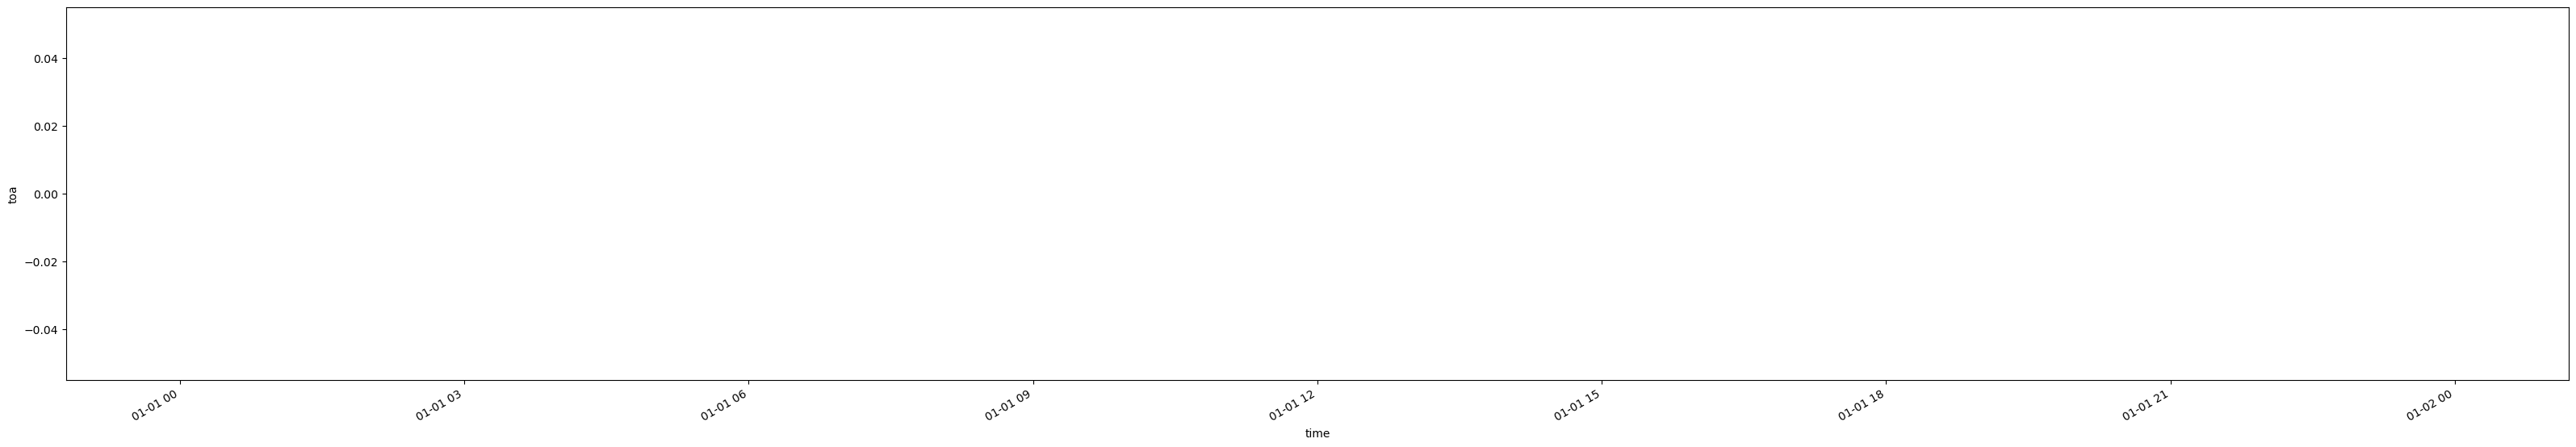

In [63]:
#plot model
fig, ax = plt.subplots(figsize = (40,6))
ds_all_canesm5.toa.plot(ax=ax)